# Xception with Data Augmentation

### Dataset:[Br35H]( https://www.kaggle.com/ahmedhamada0/brain-tumor-detection)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports

In [ ]:
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

# DataLoader 

In [ ]:
datadir = '/content/gdrive/MyDrive/Tumor'
categories = ['no', 'yes']
x = []
y = []

for category in categories:
    path = os.path.join(datadir, category)
    for image in os.listdir(path):
        images = cv2.imread(os.path.join(path, image))
        color = cv2.imread(path, cv2.COLOR_BGR2RGB)
        images = resize(images, (299, 299, 3), mode = 'constant', preserve_range = True)
        x.append(images)
        y.append(categories.index(category))

In [ ]:
no = 0
yes = 0

for i in range(len(x)):
    if y[i] == 0:
        no= no + 1
    elif y[i] == 1:
        yes = yes + 1
        
print("Total Images: ", len(x))
print("Total Images No Tumor: ", no)
print("Total Images Tumor: ", yes)

Total Images:  3000
Total Images No Tumor:  1500
Total Images Tumor:  1500


# Class Binarization

>0 = No tumor
>1 =Tumor



In [ ]:
target_dict={k: v for v, k in enumerate(np.unique(y))} 
target_val=  [target_dict[y[i]] 
              for i in range(len(y))]

## Split (Train, Test, Validation)


In [ ]:
X2, X_test, y2, y_test = train_test_split(x, y, test_size=0.1,random_state=42,shuffle=True,stratify=y) # Test
X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.2,random_state=42,shuffle=True,stratify=y2) #Training(80%) and Validation(20%)

print('Train size:', len(X_train))
print('Validation size:', len(X_val))
print('Test size:', len(X_test))

Train size: 2160
Validation size: 540
Test size: 300


In [ ]:
classes = np.unique (y_train)
classes_num = len(classes)

print ('Outputs: ', classes_num)
print ('Classes: ', classes)

Outputs:  2
Classes:  [0 1]


## Xception 


In [ ]:
!pip install tf-explain # to use pre trained

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as pl
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    include_top=False)
base_model.trainable = False #Setting trainable to False empties the list of trainable weights of the layer or model.
 
base_model.summary()
                

83683744/83683744 [==============================] - 4s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(299,299,3))
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
            optimizer="adam",
              metrics=["accuracy"])

## Training

In [ ]:
x_test = np.array(X_test) 
x_train = np.array(X_train)
y_test = np.array(y_test)
y_train = np.array(y_train)
x_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)
print (x_val.shape, y_val.shape)

(2160, 299, 299, 3) (2160,)
(300, 299, 299, 3) (300,)
(540, 299, 299, 3) (540,)


# Model Fit

In [ ]:
history = model.fit(x_train, y_train, epochs=60, batch_size = 64, validation_data=(x_val, y_val)) 

Epoch 1/60
34/34 [==============================] - 38s 806ms/step - loss: 27.8131 - accuracy: 0.7306 - val_loss: 12.2820 - val_accuracy: 0.8352
Epoch 2/60
34/34 [==============================] - 19s 555ms/step - loss: 8.4987 - accuracy: 0.8532 - val_loss: 4.1558 - val_accuracy: 0.9185
Epoch 3/60
34/34 [==============================] - 19s 560ms/step - loss: 3.3072 - accuracy: 0.9218 - val_loss: 2.8335 - val_accuracy: 0.9315
Epoch 4/60
34/34 [==============================] - 19s 567ms/step - loss: 1.7197 - accuracy: 0.9361 - val_loss: 1.1159 - val_accuracy: 0.9667
Epoch 5/60
34/34 [==============================] - 20s 585ms/step - loss: 1.6211 - accuracy: 0.9431 - val_loss: 1.7168 - val_accuracy: 0.9426
Epoch 6/60
34/34 [==============================] - 20s 585ms/step - loss: 1.5102 - accuracy: 0.9431 - val_loss: 4.4577 - val_accuracy: 0.8537
Epoch 7/60
34/34 [==============================] - 21s 623ms/step - loss: 1.8127 - accuracy: 0.9403 - val_loss: 1.1923 - val_accuracy: 0.96

In [ ]:
model.save('/content/gdrive/MyDrive/Bracis/BD/modelBr35HDataAug2.h5')

## Model Evaluate

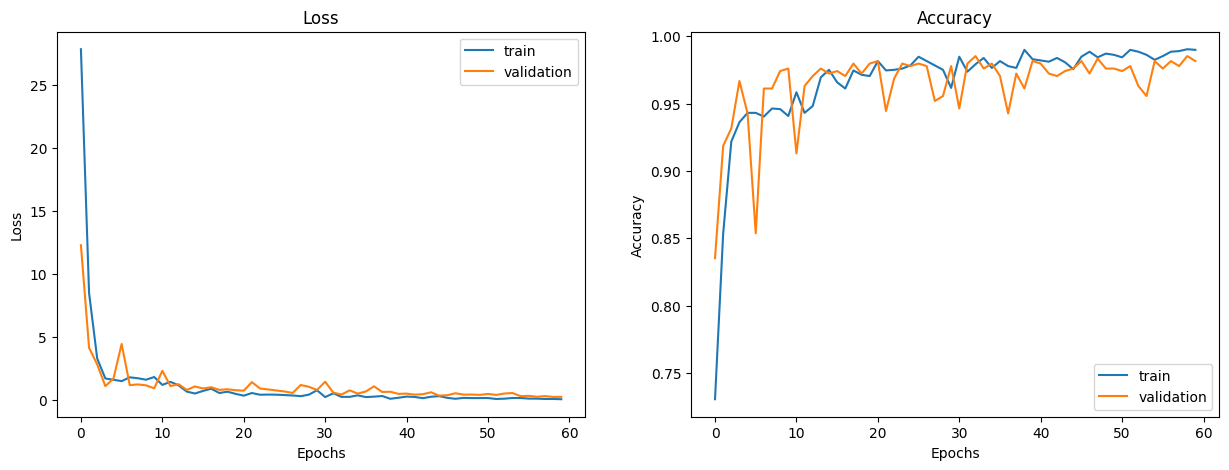

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend();
plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend();

In [ ]:
print ('Loss and Accuracy:')
model.evaluate(x_test, y_test)

Loss and Accuracy:
10/10 [==============================] - 6s 364ms/step - loss: 0.6125 - accuracy: 0.9733


[0.6124626398086548, 0.9733333587646484]

10/10 [==============================] - 3s 220ms/step


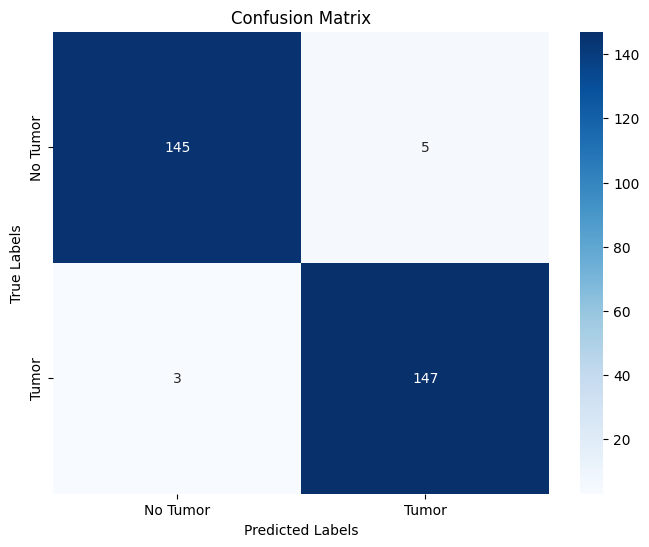

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

cmat=confusion_matrix(y_test,y_pred,labels=[0,1])
cm_df = pd.DataFrame(cmat)

cmat_df = pd.DataFrame(cmat,
                     index = ['No Tumor','Tumor' ], 
                     columns = ['No Tumor','Tumor' ])

plt.figure(figsize=(8,6))
sns.heatmap(cmat_df, annot=True,fmt="d",cmap=plt.cm.Blues )
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [ ]:
tp = cmat[1][1] # True positive
fp = cmat[0][1] # False positive
tn = cmat[0][0] # True negative
fn = cmat[1][0] # False negative

accuracy = ((tp+tn)*100)/np.sum(cmat)
precision = (tp*100)/(tp+fp)
sensibility = (tp*100/(tp+fn))
specificity = (tn*100)/(fp+tn)

print('Metrics')
print('Accuracy:..........>',accuracy,"%")
print('Precision:..........>',precision,"%")
print('Recall:.....>',sensibility,"%")
print('Specificity:....>',specificity,"%")

plt.show()

Metrics
Accuracy:..........> 97.33333333333333 %
Precision:..........> 96.71052631578948 %
Recall:.....> 98.0 %
Specificity:....> 96.66666666666667 %


## ROC Curve

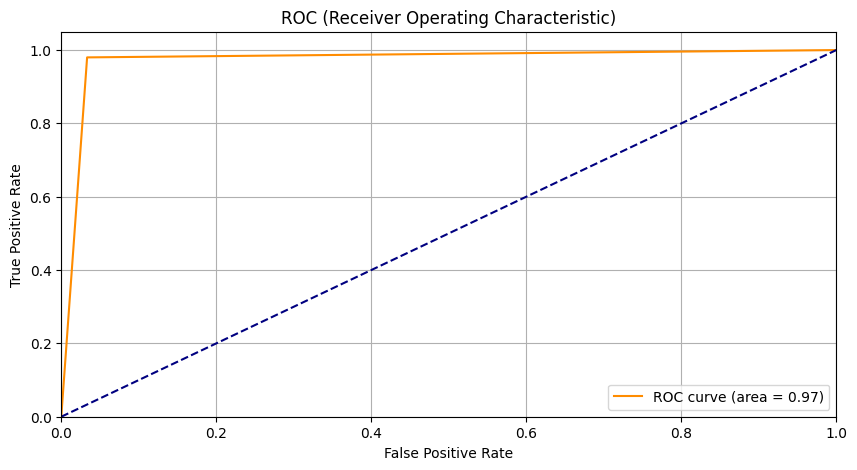

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Predictions

1/1 [==============================] - 0s 452ms/step


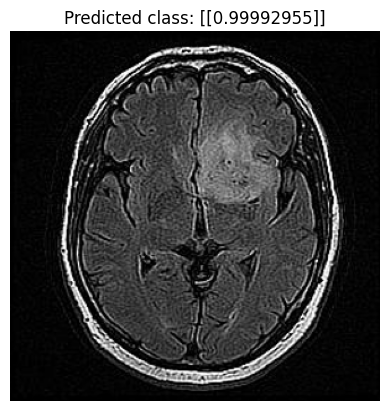

In [ ]:
import numpy as np
from PIL import Image


# Load and preprocess the image
img = Image.open("/content/gdrive/MyDrive/Tumor/yes/y1200.jpg")
img = img.resize((299, 299))
img_arr = np.array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = img_arr.astype("float32") / 255

# Make predictions
preds = model.predict(tf.constant(img_arr))
# Plot the image and the predicted class
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted class: {preds}")
plt.show()

1/1 [==============================] - 0s 22ms/step


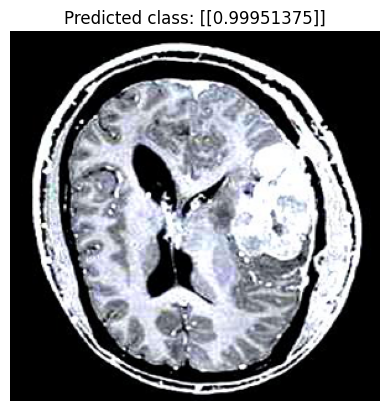

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
from PIL import Image

# Load and preprocess the image
img = Image.open("/content/gdrive/MyDrive/Tumor/yes/y12.jpg")
img = img.resize((299, 299))
img_arr = np.array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = img_arr.astype("float32") / 255

# Make predictions
preds = model.predict(tf.constant(img_arr))
# Plot the image and the predicted class
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted class: {preds}")
plt.show()

1/1 [==============================] - 0s 23ms/step


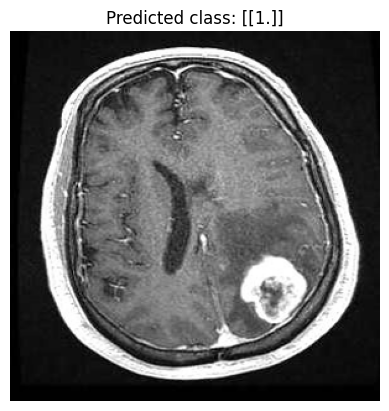

In [ ]:
# Load and preprocess the image
img = Image.open("/content/gdrive/MyDrive/Tumor/yes/y333.jpg")
img = img.resize((299, 299))
img_arr = np.array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = img_arr.astype("float32") / 255

# Make predictions
preds = model.predict(tf.constant(img_arr))
# Plot the image and the predicted class
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted class: {preds}")
plt.show()

1/1 [==============================] - 0s 24ms/step


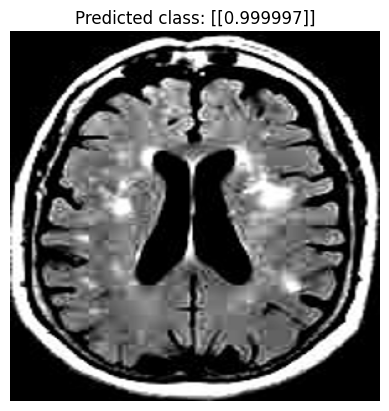

In [ ]:
import numpy as np
from PIL import Image

# Load and preprocess the image
img = Image.open("/content/gdrive/MyDrive/Tumor/no/no1.jpg")
img = img.resize((299, 299))
img_arr = np.array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = img_arr.astype("float32") / 255

# Make predictions
preds = model.predict(tf.constant(img_arr))
# Plot the image and the predicted class
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted class: {preds}")
plt.show()

1/1 [==============================] - 0s 22ms/step


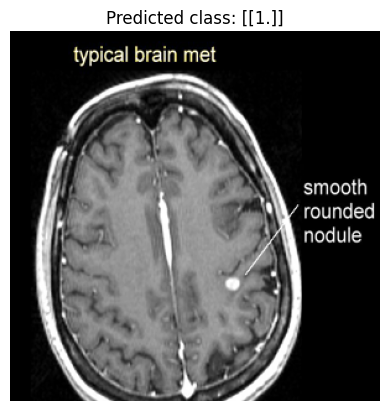

In [ ]:
# Load and preprocess the image
img = Image.open("/content/gdrive/MyDrive/Bracis/1207met.jpg")
img = img.resize((299, 299))
img_arr = np.array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = img_arr.astype("float32") / 255

# Make predictions
preds = model.predict(tf.constant(img_arr))
# Plot the image and the predicted class
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted class: {preds}")
plt.show()

# References:
* https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6
* https://www.tensorflow.org/guide/keras?hl=pt-br
* https://keras.io/guides/
* https://bioinfo.com.br/metricas-de-avaliacao-em-machine-learning-acuracia-sensibilidade-precisao-especificidade-e-f-score/ 

Book: Deep Learning With Python [François Chollet, 2021] - Second Edition

Chapter 5 - Fundamentals of machine learning

Chapter 8 - Introduction to Deep Learning for computer vision

Dataset: [Br35H](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection)